## Import Packages

In [1]:
import networkx as nx
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
import sklearn.metrics
from sklearn.metrics import silhouette_score

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 

import community as community_louvain

from collections import Counter

import networkx.algorithms.community as nx_comm
import networkx.algorithms.flow as nx_flow
import networkx.algorithms.shortest_paths as nx_path

import collections
import itertools

## Read in and Clean Data

In [2]:
studied_proteins = {
    'DIC1': '4932.YLR348C',
    'RGT2': '4932.YDL138W',
    'CBF5': '4932.YLR175W',
    'EST2': '4932.YLR318W'
}

In [3]:
# Generate common name for yeast proteins
temp_df = pd.read_table("../4932.protein.info.v11.5.txt",delimiter='\t')
common_name = dict(temp_df.iloc[:,:2].values)

In [4]:
# Read in essential node data
essential_df = pd.read_csv('essential.csv', header=None)

In [5]:
# Read in preprocessed uniprot data
uniprot_df = pd.read_csv('uniprot_processed.csv')

In [6]:
# Read in dataframe for detailed protein links
G_dataframe = pd.read_table("../4932.protein.links.detailed.v11.5.txt",delimiter=' ')

In [7]:
# Reweight edges of protein links
keep_columns = [
    'neighborhood', 'fusion', 'cooccurence', 
    'coexpression', 'experimental', 'database', 
    'textmining'
]

# Double weight of experimental evidence
G_dataframe['experimental'] *= 2

# Half weight of textmining
G_dataframe['textmining'] //=2

# Calculate combined score
G_dataframe.combined_score = G_dataframe[keep_columns].max(axis=1)

# Drop edges with combined score of zero
G_dataframe = G_dataframe.drop(G_dataframe[G_dataframe.combined_score == 0].index)

In [8]:
# Drop edges with combined score of <= threshold score
threshold_score = 600
G_dataframe = G_dataframe.drop(
    G_dataframe[G_dataframe.combined_score <= threshold_score].index
    )

In [9]:
# Sanity check of data

G_dataframe

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
67,4932.Q0045,4932.YML120C,0,0,0,0,0,900,55,900
71,4932.Q0045,4932.YOR257W,0,0,0,0,630,0,0,630
73,4932.Q0045,4932.YPL172C,155,0,370,499,630,0,419,630
75,4932.Q0045,4932.YGR033C,0,0,0,0,702,0,0,702
80,4932.Q0045,4932.YKL192C,0,0,0,49,1060,0,116,1060
...,...,...,...,...,...,...,...,...,...,...
1988527,4932.YPR203W,4932.YER189W,0,0,0,872,0,0,0,872
1988542,4932.YPR204W,4932.YPR018W,0,0,0,0,840,0,0,840
1988553,4932.YPR204W,4932.YBL032W,0,0,0,0,630,0,0,630
1988565,4932.YPR204W,4932.YNL255C,0,0,0,0,630,0,0,630


## Create PPI Network

In [10]:
# Create nx graph

G = nx.from_pandas_edgelist(G_dataframe, 
    source='protein1', 
    target='protein2', 
    edge_attr=True)

In [11]:
# Ignore certain nodes in the protein network, and also combine uniprot data
# Remove proteins that are not in a location that we are targeting
# (we target membrane, mitochrondrial, cytoplasm and nucleus proteins)

irrelevant_proteins = []

# remove proteins that are ribosomal
ribosomal_proteins = []

row_index = {}

for node in G.nodes:
    # Get row index of matching row for a protein
    node_name = node.split('.')[1]
    node_matches = uniprot_df['Gene Names'].str.contains(node_name).fillna(False)
    node_uniprot = uniprot_df.index[node_matches][0]

    if uniprot_df['location_match'][node_uniprot] == 0:
        irrelevant_proteins.append(node)

    elif uniprot_df['ribosomal'][node_uniprot] == True:
        ribosomal_proteins.append(node)

    else:
        row_index[node] = node_uniprot

print(f"{len(irrelevant_proteins)=}, {len(ribosomal_proteins)=}")
print(f"{len(G.nodes)=}")
G.remove_nodes_from(irrelevant_proteins)
G.remove_nodes_from(ribosomal_proteins)
print(f"{len(G.nodes)=}")

len(irrelevant_proteins)=1334, len(ribosomal_proteins)=312
len(G.nodes)=5912
len(G.nodes)=4266


In [12]:
# Track location of nodes
node_location = {}

mitochondrial_proteins = set()
cytoplasm_proteins = set()
membrane_proteins = set()
nucleus_proteins = set()

for node in G.nodes:
    if uniprot_df['mitochon'][row_index[node]] == 1:
        node_location[node] = 'mitochondria'
        mitochondrial_proteins.add(node)
    elif uniprot_df['cytoplasm'][row_index[node]] == 1:
        node_location[node] = 'cytoplasm'
        cytoplasm_proteins.add(node)
    elif uniprot_df['membrane'][row_index[node]] == 1:
        node_location[node] = 'membrane'
        membrane_proteins.add(node)
    elif uniprot_df['nucleus'][row_index[node]] == 1:
        node_location[node] = 'nucleus'
        nucleus_proteins.add(node)
    else:
        node_location[node] = 'other'

nx.set_node_attributes(G, values=node_location, name='location')

In [13]:
# We remove essential proteins, but keep proteins we want to study
essential_proteins_raw = essential_df[1].values
essential_proteins = set(map(lambda x: '4932.' + x, essential_proteins_raw))
essential_proteins -= set(studied_proteins.values())
print(f"{len(G.nodes)=}")
G.remove_nodes_from(list(essential_proteins))
print(f"{len(G.nodes)=}")

len(G.nodes)=4266
len(G.nodes)=3271


In [14]:
# Let's only keep the largest connected component
largest_component = max(list(nx.connected_components(G)), key=len)
G = G.subgraph(largest_component)
print(f"{len(G.nodes)=}")

len(G.nodes)=3172


In [15]:
# Sanity check - 
#   Check proteins we are interested in are still in the network

for key, value in studied_proteins.items():
    if value not in G.nodes:
        print(f"ERROR: {key} was deleted from the network!")

In [16]:
direction = {
    'mitochondria': {'cytoplasm', 'mitochondria'},
    'cytoplasm': {'nucleus', 'mitochondria', 'cytoplasm'},
    'nucleus': {'nucleus'},
    'membrane': {'mitochondria', 'membrane'}
}

In [17]:
# Give network a direction structure

GX = nx.DiGraph()
for edge in G.edges:
    if G.nodes[edge[1]]['location'] in direction[G.nodes[edge[0]]['location']]:
        GX.add_edge(edge[0], edge[1])
    if G.nodes[edge[0]]['location'] in direction[G.nodes[edge[1]]['location']]:
        GX.add_edge(edge[1], edge[0])

In [18]:
# Find shortest path between all pairs of studied Proteins together with number of shortest paths

for start in ['DIC1', 'RGT2']:
    for end in ['CBF5', 'EST2']:
        try:
            print('\n'.join(list(map(common_name.get, nx_path.shortest_path(GX, 
            studied_proteins[start], 
            studied_proteins[end])))),end='\n\n')
            print(len(list(nx_path.all_shortest_paths(GX, 
            studied_proteins[start], 
            studied_proteins[end]))))
        except:
            print('fail', start, end)

DIC1
PUF3
CBF5

1
DIC1
PUF3
HEK2
EST2

6
RGT2
GPR1
RAS2
PUF3
CBF5

4
RGT2
GPR1
RAS2
PUF3
HEK2
EST2

22


In [19]:
# Get paths from start to end satisfying a given property

def get_paths(start, end, func, **kwargs):
    paths = list(func(GX, 
            studied_proteins[start], 
            studied_proteins[end], **kwargs))
    all_occurrences = collections.Counter(itertools.chain.from_iterable(paths))
    return (p for p in paths if 1 not in set(map(all_occurrences.get, p)))

In [20]:
# Print paths of proteins satisfying property

def print_paths(start, end, func, reverse=False, **kwargs):
    out = lambda x: ', '.join(map(common_name.get, x))
    if reverse:
        out = lambda x: ', '.join(reversed(list(map(common_name.get, x))))
    print('\n'.join(sorted(map(out, get_paths(start, end, func, **kwargs)))))

## Homotopic Clustering

In [114]:
class HomotopyNet:
    
    def __init__(self, start, end, PPI, pathlength, lap=False):
        self.start = start
        self.end = end
        self.PPI = PPI
        self.pathlength = pathlength
        self.lap = lap
        
        paths = nx.algorithms.simple_paths.all_simple_paths(GX, 
            studied_proteins[start], 
            studied_proteins[end], cutoff=pathlength)
        #allpaths = [np.array(p) for p in paths]
        pathlist = list(nx.algorithms.simple_paths.all_simple_paths(GX, 
            studied_proteins[start], 
            studied_proteins[end], cutoff=pathlength))
        allpathsets = [set(zip(p[0:-1], p[1:])) for p in pathlist]
        
        self.pathlist = pathlist
        self.allpathsets = allpathsets
        self.size = len(pathlist)
        
        HomotopyG = nx.Graph()
        for i, P in enumerate(allpathsets):
            for j, Q in enumerate(allpathsets[i+1:], start = i+1):
                weight = len(P & Q) / len(P | Q)
                if weight > 0:
                    HomotopyG.add_edge(i,j, weight = len(P & Q) / len(P | Q))
                    
            
            if i % 100 == 0:
                print(i)
        print("finished network")
                    
        self.HomotopyG = HomotopyG
        if lap:
            print("construct Laplacian")
            self.lap = nx.laplacian_matrix(HomotopyG).astype(float)
            
        self.np_mat = nx.to_numpy_matrix(self.HomotopyG)
        
    def k_Elbow(self):
        if not self.lap:
            return "Error: Adj = FALSE"
        silhouette_coeffs = []
        K = range(2, 11)
        
        for k in K:
            w,v = sp.sparse.linalg.eigsh(self.L, k=k, which = 'SM')
            X = v*w
            kmeans = KMeans(init="k-means++", n_clusters=k, n_init=10)
            kmeans.fit_predict(X)
            #centroids = kmeans.cluster_centers_
            labels = kmeans.labels_
            #error = kmeans.inertia_
            score = silhouette_score(X, labels)
            silhouette_coeffs.append(score)
        #closest = sklearn.metrics.pairwise_distances_argmin(centroids, X)
        plt.plot(K, silhouette_coeffs)
        plt.xlabel("Number of Partitions")
        plt.ylabel("Silhouette Coefficients")
        
    def indices_to_pathname(self, indices):
        
        # Takes in a list of numbers and returns their paths
        
        path_ls = [self.pathlist[i] for i in indices]
        return path_ls
    
    def KMeans_cluster(self, k):
        
        # Defunct
        
        if not self.lap:
            return "Error: Adj = FALSE"
        w,v = sp.sparse.linalg.eigsh(self.L, k=k, which = 'SM')
        X = v*w
        kmeans = KMeans(init="k-means++", n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        centroids = kmeans.cluster_centers_
        labels = kmeans.labels_
        error = kmeans.inertia_
        
        closest = sklearn.metrics.pairwise_distances_argmin(centroids, X)
        
        return closest, labels
    
    def plot(self, alpha, comms, label_true = False):
        
        # Plots HomotopyG with partition (comms) coloured.
        
        edges,weights = zip(*nx.get_edge_attributes(self.HomotopyG,'weight').items())
        
        colourmap = comms
        
        pos = nx.spring_layout(self.HomotopyG)
        nx.draw(self.HomotopyG, pos, node_color=colourmap, edgelist=edges, cmap=plt.cm.CMRmap, alpha = alpha,
                edge_color=tuple(map(np.log, weights)), 
                width=1, edge_cmap=plt.cm.binary, with_labels = label_true)
        plt.savefig(self.start + "-" + self.end + "_visual")
        
    def Spectral_Cluster(self, k):
        
        # Obtains k partition of the HomotopyG network using spectral clustering and returns the centroids + clusters
        
        clustering = SpectralClustering(k).fit(self.np_mat)
        clusters = clustering.fit_predict(self.np_mat, 2)
        
        centroids = []
        for j in range(k):
            subG = nx.induced_subgraph(self.HomotopyG, [i for i in self.HomotopyG.nodes if clusters[i] == j])
            dic = nx.eigenvector_centrality(subG)
            centroids.append(max(dic, key=dic.get))
        return centroids, clusters
    
    def Spectral_Modularity_Plot(self):
        
        # Plots modularity of spectral clusters for each integer k of clusters AND returns k with best modularity
        
        K = range(2, 11)
        levels = []
        
        for k in K:
            Spec = self.Spectral_Cluster(k)
            labs = Spec[1]
            clustersets = [set(np.where(labs == i)[0]) for i in range(0, k)]
            levels.append(clustersets)
        
        mods = [nx_comm.modularity(self.HomotopyG, levels[k-2]) for k in K]
        plt.plot(K, mods)
        plt.title(self.start + " -> " + self.end + " Modularity vs Partition number")
        plt.xlabel("Number of Partitions")
        plt.ylabel("Modularity")
        plt.savefig(self.start + "-" + self.end + "_modularity")
        
        return mods.index(max(mods)) + 2
            

In [115]:
def path_to_proteins(path):
    
    # Takes in paths (sequence of node pairs) and returns the protein pathway.
    
    out = lambda x: ', '.join(map(common_name.get, x))
    
    print('\n'.join(sorted(map(out, path))))

## DIC1 -> EST2

In [116]:
# Spectral + Modularity

In [117]:
HomNet = HomotopyNet('DIC1', 'EST2', GX, 4)
HomNet.size

0
100
200
300
400
500
finished network


563

/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


DIC1, ATP1, PUF3, HEK2, EST2
DIC1, ATP23, MGR1, HEK2, EST2
DIC1, PUF3, KIN1, ISW1, EST2
DIC1, PUF3, MRX9, HEK2, EST2
DIC1, PUF3, NAB6, ISW1, EST2
DIC1, PUF3, NAB6, MRN1, EST2


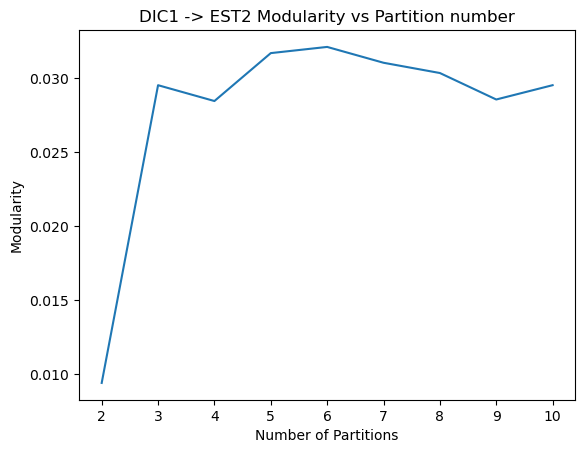

In [118]:
k = HomNet.Spectral_Modularity_Plot()
Spec = HomNet.Spectral_Cluster(k)
path_to_proteins(HomNet.indices_to_pathname(Spec[0]))

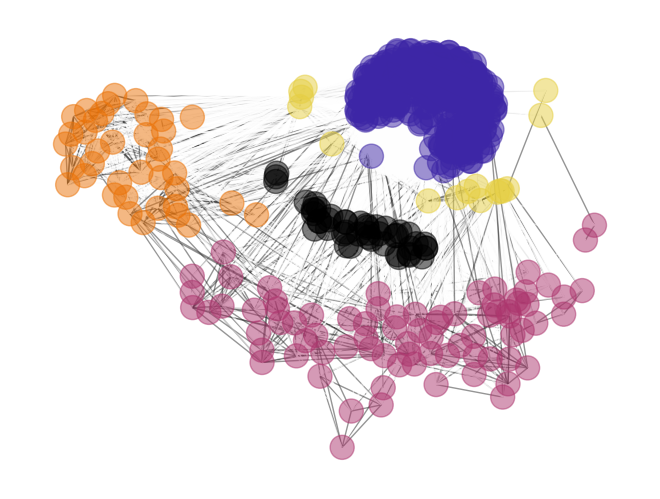

In [119]:
HomNet.plot(0.5, Spec[1])

## DIC1 -> CBF5

In [122]:
HomNet = HomotopyNet('DIC1', 'CBF5', GX, 4)
HomNet.size

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
finished network


2107

/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


DIC1, ATP1, IDH2, PUF3, CBF5
DIC1, ATP1, RIP1, PUF3, CBF5
DIC1, ATP23, GGC1, TUF1, CBF5
DIC1, ATP4, INA22, PUF3, CBF5
DIC1, PUF3, CBP4, GIS2, CBF5
DIC1, PUF3, COR1, GIS2, CBF5
DIC1, PUF3, QCR7, SRO9, CBF5
DIC1, PUF3, TDH2, CAF20, CBF5


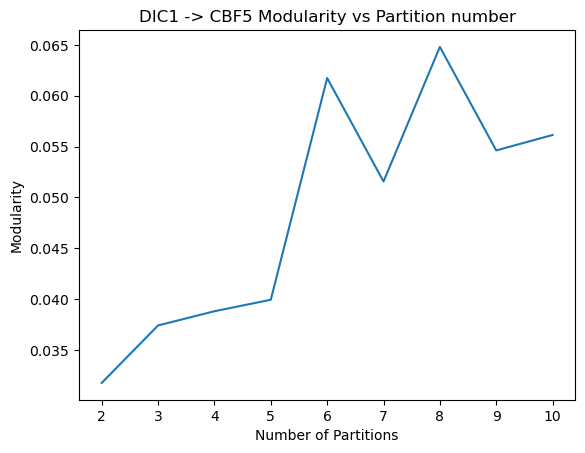

In [123]:
k = HomNet.Spectral_Modularity_Plot()
Spec = HomNet.Spectral_Cluster(k)
path_to_proteins(HomNet.indices_to_pathname(Spec[0]))

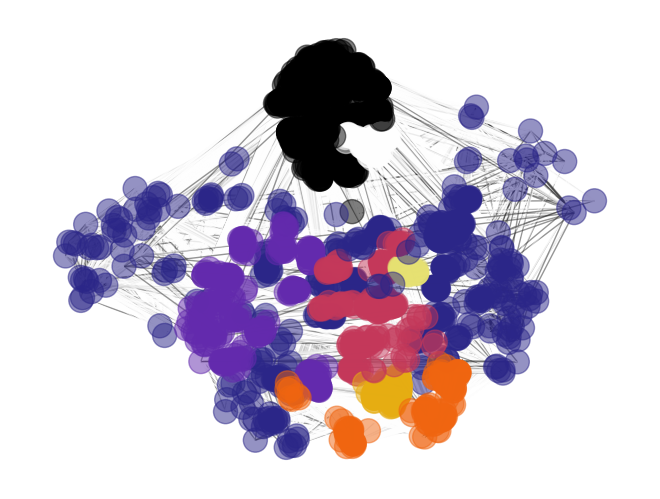

In [124]:
HomNet.plot(0.5, Spec[1])

## RGT2 -> EST2

In [125]:
HomNet = HomotopyNet('RGT2', 'EST2', GX, 5)
HomNet.size

0
finished network


22

/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


RGT2, BPT1, YOR1, PUF3, PUB1, EST2
RGT2, GPR1, RAS2, PHB1, TOR1, EST2
RGT2, SNF3, HXT3, PUF3, HEK2, EST2


/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


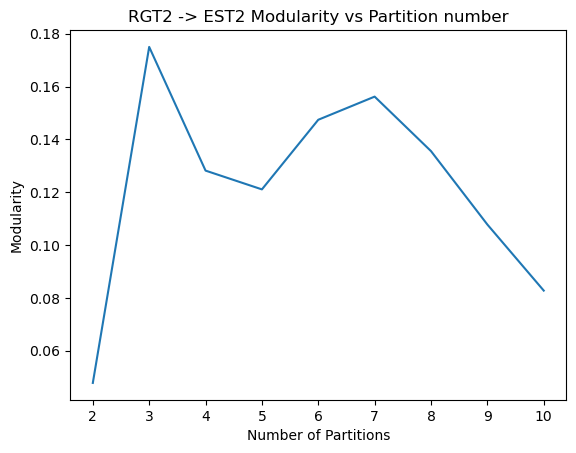

In [126]:
k = HomNet.Spectral_Modularity_Plot()
Spec = HomNet.Spectral_Cluster(k)
path_to_proteins(HomNet.indices_to_pathname(Spec[0]))

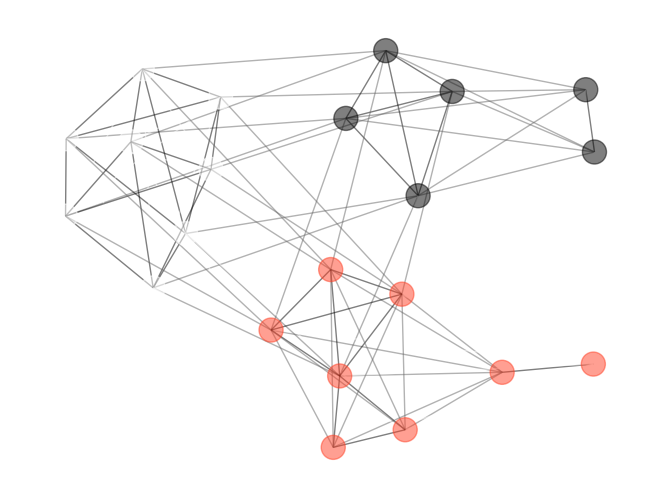

In [127]:
HomNet.plot(0.5, Spec[1])

## RGT2 -> CBF5

In [128]:
HomNet = HomotopyNet('RGT2', 'CBF5', GX, 5)
HomNet.size

0
100
finished network


161

/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/Users/incarnate/opt/anaconda3/envs/networkx/lib/python3.10/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


RGT2, BPT1, YOR1, PUF3, CBF5
RGT2, GPR1, RAS2, PHB1, AAC1, CBF5
RGT2, SNF3, HXT2, MUP1, PUF3, CBF5


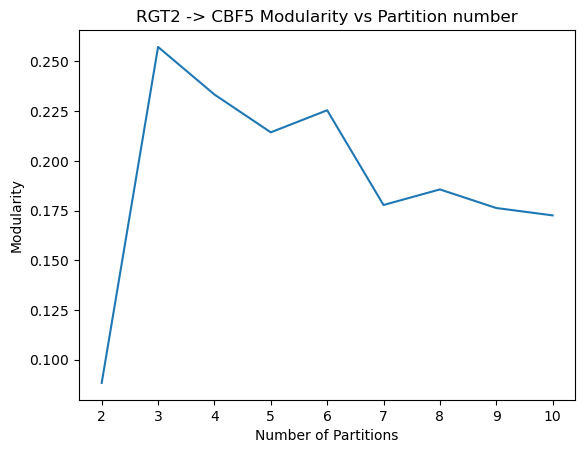

In [129]:
k = HomNet.Spectral_Modularity_Plot()
Spec = HomNet.Spectral_Cluster(k)
path_to_proteins(HomNet.indices_to_pathname(Spec[0]))

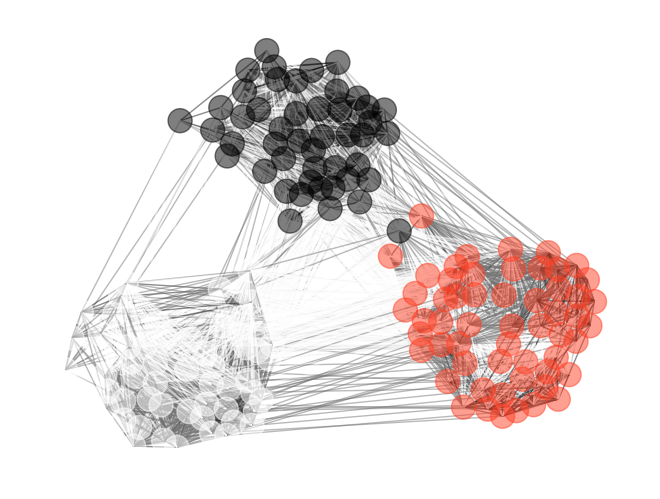

In [130]:
HomNet.plot(0.5, Spec[1])